In [ ]:
#          #########################################################################
#          #                           IN THE NAME OF ALLAH                        #
#          #    STRUCTURE DUCTILITY DAMAGE INDEX OF TRUSS BRIDGE SUPERSTRUCTURE    #
#          #-----------------------------------------------------------------------#
#          #              THIS PROGRAM WRITTEN BY SALAR DELAVAR QASHQAI            #
#          #                   EMAIL: salar.d.ghashghaei@gmail.com                 #
#          #########################################################################

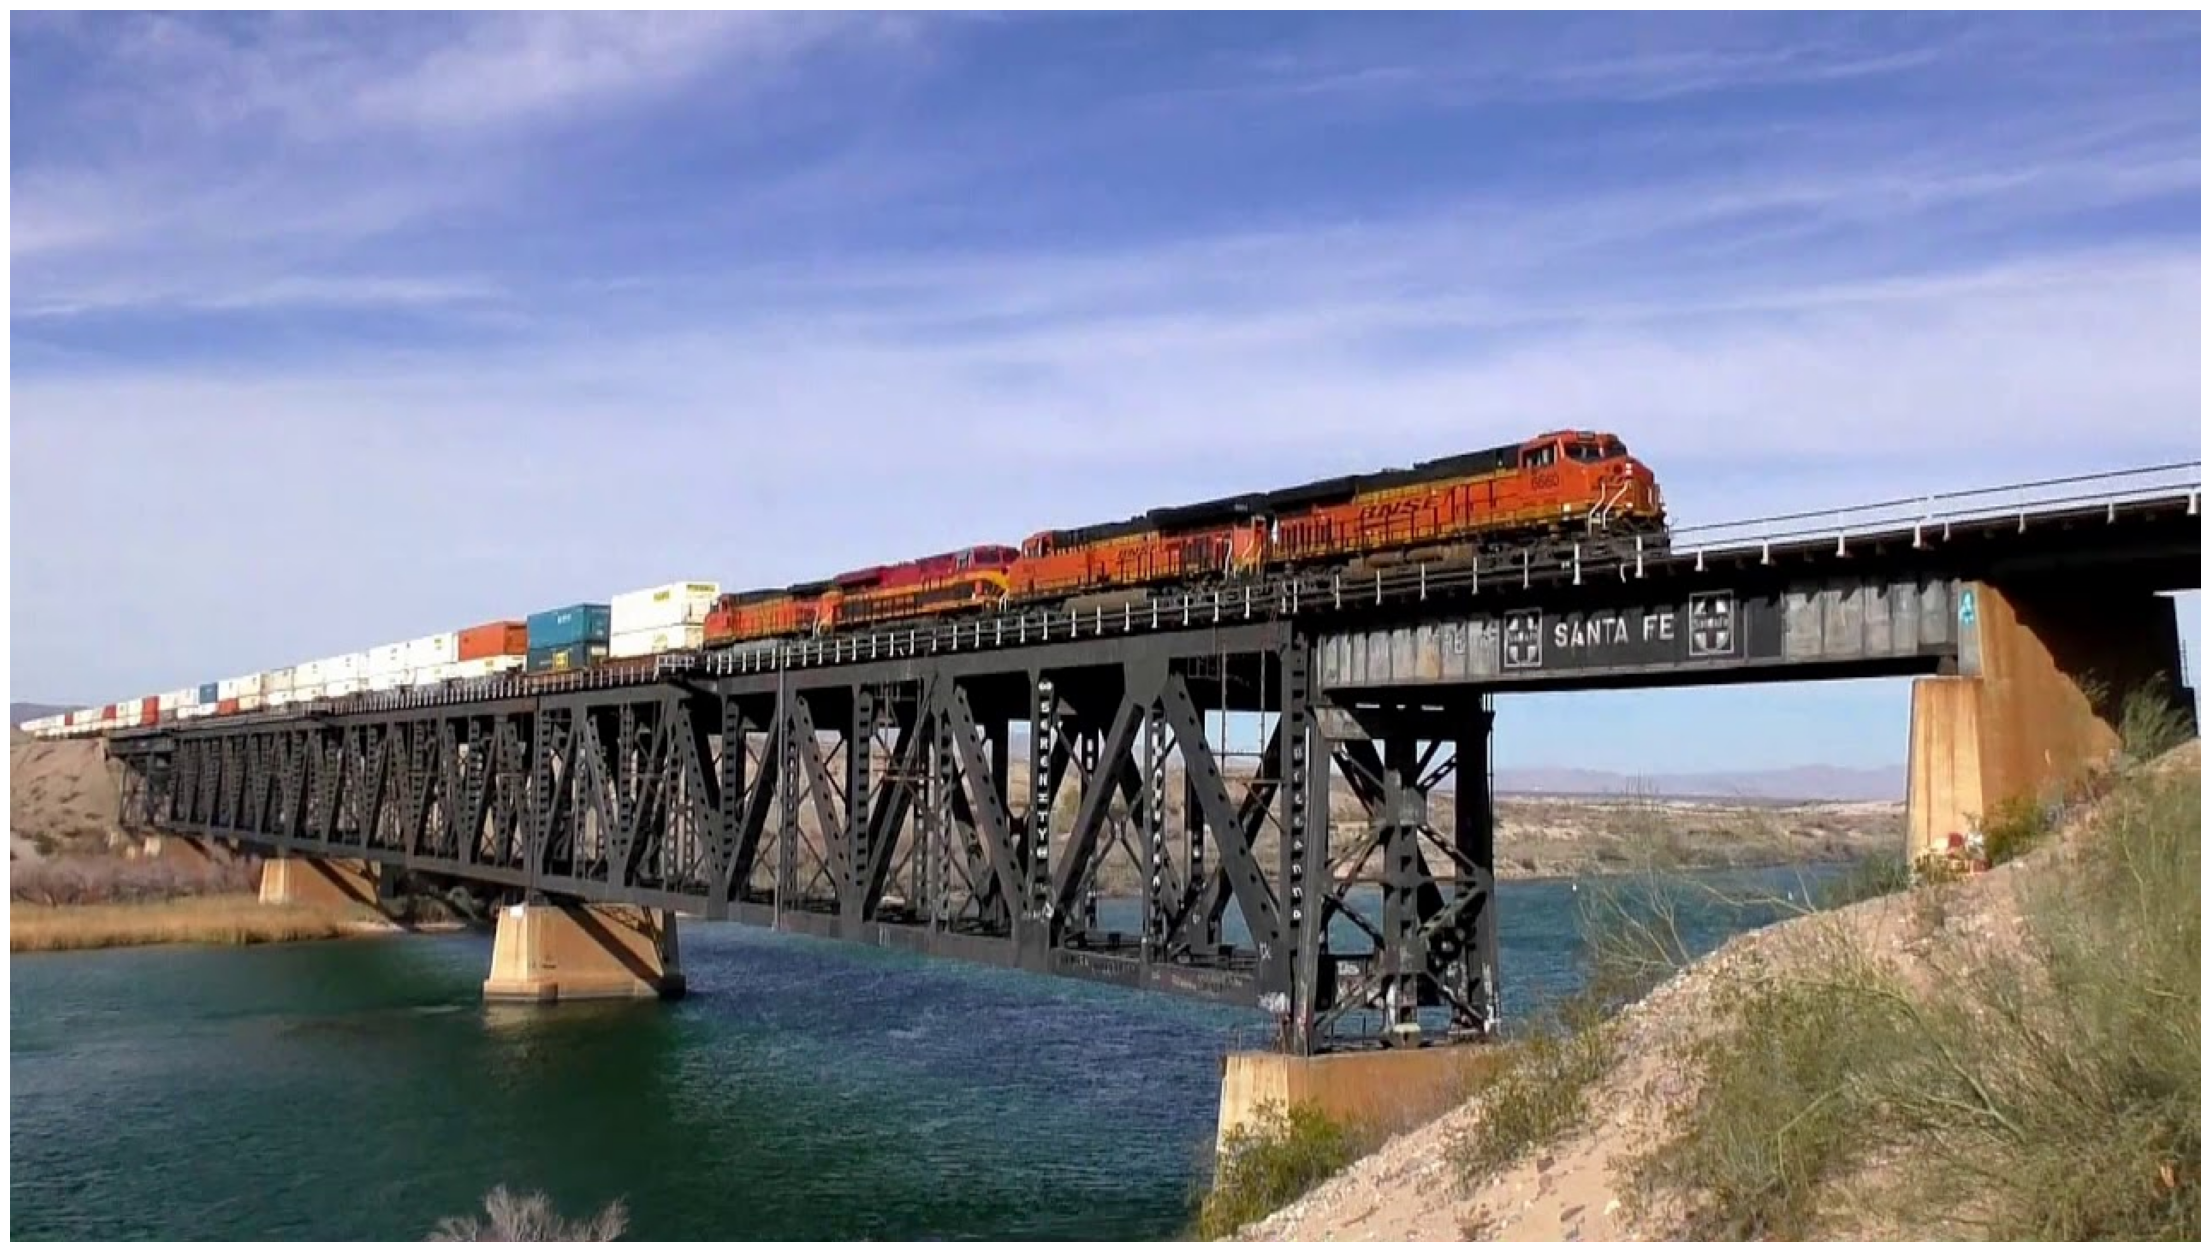

In [1]:
# Load the image
def PLOT_IMAGE(image):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    image = mpimg.imread(image_path)

    # Display the image
    plt.figure(figsize=(30, 16))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()
    
image_path = 'OPENSEES_RAILROAD_TRUSS_BRIDGE.png'    
PLOT_IMAGE(image_path)

In [ ]:
#import the os module
import os
import math
import time
import numpy as np
import openseespy.opensees as op

In [ ]:
#to create a directory at specified path with name "Data"
os.mkdir('C:\\OPENSEESPY_SALAR')

In [ ]:
FOLDER_NAME = 'TRUSS_OPTIMIZATION'
dir = f"C:\\OPENSEESPY_SALAR\\{FOLDER_NAME}\\"
if not os.path.exists(dir):
    os.makedirs(dir)

In [ ]:
## DELETE ALL FILES IN DIRECTORY 
def DELETE_FOLDER_CONTANTS(folder_path):
    import os
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")
    print("Deletion done")
   
FOLDER_PATH = f'C:\\OPENSEESPY_SALAR\\{FOLDER_NAME}'  # Specify the folder path
#DELETE_FOLDER_CONTANTS(FOLDER_PATH)   

In [ ]:
def MAXABS_FUN(DATA_FILE, COLUMN, I, J, Z):
    import numpy as np
    # Read and process displacement data
    if Z == 1:
        NameFiles = DATA_FILE
        filename = f"{NameFiles}_{I}.txt"
        D = np.loadtxt(filename)
        #print(D)
        MAXABS = np.max(np.abs([D[:, COLUMN]]))
    if Z == 2:
        NameFiles = DATA_FILE
        filename = f"{NameFiles}_{I}_{J}.txt"
        D = np.loadtxt(filename)
        #print(D)
        MAXABS = np.max(np.abs([D[:, COLUMN]]))    
    #print("MAX. ABS. :", MAXABS)
    return MAXABS
# -----------------------------------------------
def PLOT_2D(X, Y, Xfit, Yfit, XLABEL, YLABEL, TITLE, COLOR, Z):
    import matplotlib.pyplot as plt
    if Z == 1:
        # Plot 1 line
        plt.figure(figsize=(12, 8))
        plt.plot(X, Y,color=COLOR)
        plt.xlabel(XLABEL)
        plt.ylabel(YLABEL)
        plt.title(TITLE)
        plt.grid(True)
        plt.show()
    if Z == 2:
        plt.plot(X, Y, Xfit, Yfit, 'r--', linewidth=3)
        plt.title(TITLE)
        plt.xlabel(XLABEL)
        plt.ylabel(YLABEL)
        plt.legend(['curve', 'bilinear fitted'], loc='lower right')
        plt.grid(True)
        plt.show()
# -----------------------------------------------
def OUTPUT_SECOND_COLUMN(FOLDER, X, COLUMN, I, Z):
    import numpy as np
    # Time History
    if Z == 1:
        filename = f"C:\\OPENSEESPY_SALAR\\{FOLDER}\\{X}.txt"
        data_collected = np.loadtxt(filename)
        X = data_collected[:, COLUMN]
    if Z == 2:
        filename = f"C:\\OPENSEESPY_SALAR\\{FOLDER}\\{X}_{I}.txt"
        data_collected = np.loadtxt(filename)
        X = data_collected[:, COLUMN]    
    return X 
# -----------------------------------------------
def BILNEAR_CURVE(Cur, Mom, SLOPE_NODE):
    import numpy as np
    # bilinear fitting
    SIZE = len(Mom)
    hh = np.zeros(SIZE-1)
    Aa = np.zeros(SIZE-1)
    for i in range(SIZE-1):
        hh[i] = Cur[i+1] - Cur[i]
        Aa[i] = (Mom[i] + Mom[i+1]) * 0.5 * hh[i]

    Area = sum(Aa)
    k0 = Mom[SLOPE_NODE] / Cur[SLOPE_NODE]
    fiy = (Mom[i+1] * max(Cur) * 0.5 - Area) / (Mom[i+1] * 0.5 - k0 * max(Cur) * 0.5)
    My = k0 * fiy
    X = np.array([0, fiy, max(Cur)])
    Y = np.array([0, My, Mom[i+1]])
    """
    print('+==========================+')
    print('=   Analysis curve fitted =')
    print('     Disp       Baser Shear')
    print('----------------------------')
    print(np.column_stack((X.T, Y.T)))
    print('+==========================+')
    """
    # EI and Ductility_Rito of Unconfined Section
    Elastic_ST = Y[1] / X[1]
    Plastic_ST = Y[2] / X[2]
    Tangent_ST = (Y[2] - Y[1]) / (X[2] - X[1])
    Ductility_Rito = X[2] / X[1]
    Over_Strength_Factor = Y[2] / Y[1]
    """
    print('+----------------------------------------------------+')
    print(f' Structure Elastic Stiffness :     {Elastic_ST:.2f}')
    print(f' Structure Plastic Stiffness :     {Plastic_ST:.2f}')
    print(f' Structure Tangent Stiffness :     {Tangent_ST:.2f}')
    print(f' Structure Ductility Ratio :       {Ductility_Rito:.2f}')
    print(f' Structure Over Strength Factor:   {Over_Strength_Factor:.2f}')
    print('+----------------------------------------------------+')
    """
    return X, Y, Elastic_ST, Plastic_ST, Tangent_ST, Ductility_Rito, Over_Strength_Factor

In [ ]:
# pip install openseespy
# pip install --upgrade openseespy

In [ ]:
# OUTPUT DATA ADDRESS:
SALAR_DIR = f'C://OPENSEESPY_SALAR//{FOLDER_NAME}//';

In [ ]:
### -----------------------
###    PUSHOVER FUNCTION
### -----------------------

def PUSHOVER_ANALYSIS(nodes, elements, B_01, t_01, B_02, t_02, Fy, Fu, Weight, ND01, ND02, DMAX, I):
    import openseespy.opensees as op
    # Create a model builder
    op.wipe()
    op.model('basic', '-ndm', 2, '-ndf', 2)
    
    for i in range(0, 62):
        op.node(nodes[i][0], nodes[i][1], nodes[i][2])
    
    # Define boundary conditions
    op.fix(1, 1, 1)
    op.fix(11, 1, 1)
    op.fix(21, 1, 1)
    op.fix(31, 1, 1)
    
    SecTag01 = 1			# BOTTOM AND TOP TRUSS ELEMENTS
    SecTag02 = 2			# DIAGONAL TRUSS ELEMENTS
    # MATERIAL parameters -------------------------------------------------------------------
    IDreinf = 1; 				# material ID tag -- PLATE
    # PLATE MATERIAL PROPERTIES:
    Es = 200000			# Steel plate modulus of elasticity
    Cy = Fy/Es			# Steel plate yield strain
    Cu = 0.9			# Steel plate ultimate strain
    Esh = (Fu - Fy)/(Cu - Cy) # Steel plate tangent modulus of elasticity
    Bs = Esh / Es				# strain-hardening ratio 
    #Bs = 0.01				# strain-hardening ratio 
    R0 = 18.0				# control the transition from elastic to plastic branches
    cR1 = 0.925				# control the transition from elastic to plastic branches
    cR2 = 0.15				# control the transition from elastic to plastic branches
    # BOTTOM AND TOP TRUSS ELEMENTS
    op.uniaxialMaterial('Steel02', IDreinf, Fy, Es, Bs, R0,cR1,cR2) # build plate material
    # FIBER SECTION properties -------------------------------------------------------------
    # symmetric section
    #                        y
    #                        ^
    #                        |     
    #              _____________________    --  --
    #             |  _________________ |    |   -- tf
    #             | |                | |    |
    #             | |                | |    
    #    z <---   | |                | |    B
    #             | |                | |    
    #             | |________________| |    |
    #             |____________________|    |   -- tf
    #                                      --   --
    #             |-------- B ---------|
    #
    # STEEL BOX SECTION: 
    x01 = B_01 / 2.0
    y01 = B_01 / 2.0
    x02 = (B_01 - t_01) / 2.0
    y02 = (B_01 - t_01) / 2.0
    nfCoreY = 60;			# number of fibers for steel in y-direction
    nfCoreZ = 30;			# number of fibers for steel in z-direction
    op.section('Fiber', SecTag01)
    # Define the core patch
    op.patch('quad', IDreinf, nfCoreZ, nfCoreY, y02, x01, y02, -x01, y01, -x01, y01, x01) # TOP PLATE
    op.patch('quad', IDreinf, nfCoreZ, nfCoreY, -y02, x01, -y02, -x01, -y01, -x01, -y01, -x01) # BOTTOM PLATE
    op.patch('quad', IDreinf, nfCoreZ, nfCoreY, y02, x01, y02, x02, -y02, x02, -y02, x01) # MIDDLE RIGHT PLATE
    op.patch('quad', IDreinf, nfCoreZ, nfCoreY, y02, -x01, y02, -x02, -y02, -x02, -y02, -x01) # MIDDLE LEFT PLATE    
    # -----------------------------------------------------------------------------------------------------
    # DIAGONAL TRUSS ELEMENTS
    # FIBER SECTION properties -------------------------------------------------------------
    # symmetric section
    #                        y
    #                        ^
    #                        |     
    #              _____________________    --  --
    #             |  _________________ |    |   -- tf
    #             | |                | |    |
    #             | |                | |    
    #    z <---   | |                | |    B
    #             | |                | |    
    #             | |________________| |    |
    #             |____________________|    |   -- tf
    #                                      --   --
    #             |-------- B ---------|
    #
    # STEEL BOX SECTION: 
    x01 = B_02 / 2.0
    y01 = B_02 / 2.0
    x02 = (B_02 - t_02) / 2.0 
    y02 = (B_02 - t_02) / 2.0
    nfCoreY = 60;			# number of fibers for steel in y-direction
    nfCoreZ = 30;			# number of fibers for steel in z-direction
    op.section('Fiber', SecTag02)
    # Define the core patch
    op.patch('quad', IDreinf, nfCoreZ, nfCoreY, y02, x01, y02, -x01, y01, -x01, y01, x01) # TOP PLATE
    op.patch('quad', IDreinf, nfCoreZ, nfCoreY, -y02, x01, -y02, -x01, -y01, -x01, -y01, -x01) # BOTTOM PLATE
    op.patch('quad', IDreinf, nfCoreZ, nfCoreY, y02, x01, y02, x02, -y02, x02, -y02, x01) # MIDDLE RIGHT PLATE
    op.patch('quad', IDreinf, nfCoreZ, nfCoreY, y02, -x01, y02, -x02, -y02, -x02, -y02, -x01) # MIDDLE LEFT PLATE
    # -----------------------------------------------------------------------------------------------------
    for j in range(121):
        op.element('trussSection', elements[j][0], elements[j][1], elements[j][2], elements[j][3])
        # Recorder for element forces
        op.recorder('Element', '-file', f'{SALAR_DIR}PUSH_elementForces_{I}_{j}.txt', '-time', '-ele', elements[j][0], 'section', 1, 'force')
        # Recorder for element stress-strain
        op.recorder('Element', '-file', f'{SALAR_DIR}PUSH_fiber_StressStrain_{I}_{j}.txt', '-time', '-ele', elements[j][0], 'section', 1,'fiber', y01, x01,'stressStrain')# steel fiber    
    # Recorder for node displacements
    for j in range(62):
        op.recorder('Node', '-file', f'{SALAR_DIR}PUSH_nodeDisplacements_{I}_{j}.txt','-time', '-node', nodes[j][0], '-dof', 1,2, 'disp')# Displacement Time History
    
    
    #import InelasticFiberSection
    op.recorder('Node', '-file', f"{SALAR_DIR}DTH_PUSH_{I}.txt",'-time', '-node', ND01, '-dof', 1,2, 'disp')# Displacement Time History Node 2
    op.recorder('Node', '-file', f"{SALAR_DIR}BTH_PUSH_01_{I}.txt",'-time', '-node', 1, '-dof', 1,2, 'reaction')# Base Shear Time History Node 1
    op.recorder('Node', '-file', f"{SALAR_DIR}BTH_PUSH_11_{I}.txt",'-time', '-node', 11, '-dof', 1,2, 'reaction')# Base Shear Time History Node 3
    op.recorder('Node', '-file', f"{SALAR_DIR}BTH_PUSH_21_{I}.txt",'-time', '-node', 21, '-dof', 1,2, 'reaction')# Base Shear Time History Node 3
    op.recorder('Node', '-file', f"{SALAR_DIR}BTH_PUSH_31_{I}.txt",'-time', '-node', 31, '-dof', 1,2, 'reaction')# Base Shear Time History Node 3
    
    #defining gravity loads
    op.timeSeries('Linear', 1)
    op.pattern('Plain', 1, 1)
    for j in range(1, 63): 
        op.load(j, 0.0, -Weight)
    print('Model Built')
    
    Tol = 1e-8 # convergence tolerance for test
    Iter = 1000# convergence iteration for test
    NstepGravity = 10
    DGravity = 1 / NstepGravity
    op.integrator('LoadControl', DGravity) # determine the next time step for an analysis
    op.numberer('Plain') # renumber dof's to minimize band-width (optimization), if you want to
    op.system('BandGeneral') # how to store and solve the system of equations in the analysis
    op.constraints('Plain') # how it handles boundary conditions
    op.test('NormDispIncr', Tol, Iter) # determine if convergence has been achieved at the end of an iteration step
    op.algorithm('Newton') # use Newton's solution algorithm: updates tangent stiffness at every iteration
    op.analysis('Static') # define type of analysis static or transient
    op.analyze(NstepGravity) # apply gravity

    op.loadConst('-time', 0.0) #maintain constant gravity loads and reset time to zero
    
    
    Dincr = 0.001 * DMAX
    Hload = 1#Weight
    maxNumIter = 1000
    tol = 1e-8

    op.timeSeries('Linear', 2)
    op.pattern('Plain', 200, 2)
    op.load(ND01, 0.0, -Hload)

    op.wipeAnalysis()
    op.constraints('Plain')
    op.numberer('Plain')
    op.system('BandGeneral')
    op.test('EnergyIncr', Tol, maxNumIter)
    op.algorithm('Newton')
    
    ## ND01 INCREMENTAL DISPLACEMENT NODE i
    ## ND02 INCREMENTAL DISPLACEMENT NODE j
    IDctrlDOF = 2 ## INCREMENTAL DISPLACEMENT IN Y DIRECTION
    op.integrator('DisplacementControl', ND01, IDctrlDOF, Dincr)
    op.integrator('DisplacementControl', ND02, IDctrlDOF, Dincr)
    op.analysis('Static')


    Nsteps =  int(DMAX/ Dincr)

    ok = op.analyze(Nsteps)
    #print(ok)

    # for gravity analysis, load control is fine, 0.1 is the load factor increment (http://opensees.berkeley.edu/wiki/index.php/Load_Control)

    test = {1:'NormDispIncr', 2: 'RelativeEnergyIncr', 4: 'RelativeNormUnbalance',5: 'RelativeNormDispIncr', 6: 'NormUnbalance'}
    algorithm = {1:'KrylovNewton', 2: 'SecantNewton' , 4: 'RaphsonNewton',5: 'PeriodicNewton', 6: 'BFGS', 7: 'Broyden', 8: 'NewtonLineSearch'}

    for i in test:
        for j in algorithm:

            if ok != 0:
                if j < 4:
                    op.algorithm(algorithm[j], '-initial')

                else:
                    op.algorithm(algorithm[j])

                op.test(test[i], Tol, 1000)
                ok = op.analyze(Nsteps)                            
                #print(test[i], algorithm[j], ok)             
                if ok == 0:
                    break
            else:
                continue

    #u2 = op.nodeDisp(2, 1)
    #print("u2 = ", u2)
    print(f'Pushover Done.')
    op.wipe()
    

In [ ]:
### ----------------------
###    DYNAMIC FUNCTION
### ----------------------

def DYNAMIC_ANALYSIS(nodes, elements, B_01, t_01, B_02, t_02, Fy, Fu, Mass, Weight, ND01, I):
    import openseespy.opensees as op
    op.wipe()
    op.model('basic', '-ndm', 2, '-ndf', 2) 
    #g =  9810 # mm/s^2
    # nodal coordinates:

    for i in range(0, 62):
        op.node(nodes[i][0], nodes[i][1], nodes[i][2])
    
    # Define boundary conditions
    op.fix(1, 1, 1)
    op.fix(11, 1, 1)
    op.fix(21, 1, 1)
    op.fix(31, 1, 1)
    
    # Define Mass
    for j in range(1, 63): 
        op.mass(j, 0.0, Mass)
    
    SecTag01 = 1			# BOTTOM AND TOP TRUSS ELEMENTS
    SecTag02 = 2			# DIAGONAL TRUSS ELEMENTS
    # MATERIAL parameters -------------------------------------------------------------------
    IDreinf = 1; 				# material ID tag -- PLATE
    # PLATE MATERIAL PROPERTIES:
    Es = 200000			# Steel plate modulus of elasticity
    Cy = Fy/Es			# Steel plate yield strain
    Cu = 0.9			# Steel plate ultimate strain
    Esh = (Fu - Fy)/(Cu - Cy) # Steel plate tangent modulus of elasticity
    Bs = Esh / Es				# strain-hardening ratio 
    #Bs = 0.01				# strain-hardening ratio 
    R0 = 18.0				# control the transition from elastic to plastic branches
    cR1 = 0.925				# control the transition from elastic to plastic branches
    cR2 = 0.15				# control the transition from elastic to plastic branches
    # BOTTOM AND TOP TRUSS ELEMENTS
    op.uniaxialMaterial('Steel02', IDreinf, Fy, Es, Bs, R0,cR1,cR2) # build plate material
    # FIBER SECTION properties -------------------------------------------------------------
    # symmetric section
    #                        y
    #                        ^
    #                        |     
    #              _____________________    --  --
    #             |  _________________ |    |   -- tf
    #             | |                | |    |
    #             | |                | |    
    #    z <---   | |                | |    B
    #             | |                | |    
    #             | |________________| |    |
    #             |____________________|    |   -- tf
    #                                      --   --
    #             |-------- B ---------|
    #
    # STEEL BOX SECTION: 
    x01 = B_01 / 2.0
    y01 = B_01 / 2.0
    x02 = (B_01 - t_01) / 2.0
    y02 = (B_01 - t_01) / 2.0
    nfCoreY = 60;			# number of fibers for steel in y-direction
    nfCoreZ = 30;			# number of fibers for steel in z-direction
    op.section('Fiber', SecTag01)
    # Define the core patch
    op.patch('quad', IDreinf, nfCoreZ, nfCoreY, y02, x01, y02, -x01, y01, -x01, y01, x01) # TOP PLATE
    op.patch('quad', IDreinf, nfCoreZ, nfCoreY, -y02, x01, -y02, -x01, -y01, -x01, -y01, -x01) # BOTTOM PLATE
    op.patch('quad', IDreinf, nfCoreZ, nfCoreY, y02, x01, y02, x02, -y02, x02, -y02, x01) # MIDDLE RIGHT PLATE
    op.patch('quad', IDreinf, nfCoreZ, nfCoreY, y02, -x01, y02, -x02, -y02, -x02, -y02, -x01) # MIDDLE LEFT PLATE    
    # -----------------------------------------------------------------------------------------------------
    # DIAGONAL TRUSS ELEMENTS
    # FIBER SECTION properties -------------------------------------------------------------
    # symmetric section
    #                        y
    #                        ^
    #                        |     
    #              _____________________    --  --
    #             |  _________________ |    |   -- tf
    #             | |                | |    |
    #             | |                | |    
    #    z <---   | |                | |    B
    #             | |                | |    
    #             | |________________| |    |
    #             |____________________|    |   -- tf
    #                                      --   --
    #             |-------- B ---------|
    #
    # STEEL BOX SECTION: 
    x01 = B_02 / 2.0
    y01 = B_02 / 2.0
    x02 = (B_02 - t_02) / 2.0 
    y02 = (B_02 - t_02) / 2.0
    nfCoreY = 60;			# number of fibers for steel in y-direction
    nfCoreZ = 30;			# number of fibers for steel in z-direction
    op.section('Fiber', SecTag02)
    # Define the core patch
    op.patch('quad', IDreinf, nfCoreZ, nfCoreY, y02, x01, y02, -x01, y01, -x01, y01, x01) # TOP PLATE
    op.patch('quad', IDreinf, nfCoreZ, nfCoreY, -y02, x01, -y02, -x01, -y01, -x01, -y01, -x01) # BOTTOM PLATE
    op.patch('quad', IDreinf, nfCoreZ, nfCoreY, y02, x01, y02, x02, -y02, x02, -y02, x01) # MIDDLE RIGHT PLATE
    op.patch('quad', IDreinf, nfCoreZ, nfCoreY, y02, -x01, y02, -x02, -y02, -x02, -y02, -x01) # MIDDLE LEFT PLATE
    # -----------------------------------------------------------------------------------------------------
    
    for j in range(121):
        op.element('trussSection', elements[j][0], elements[j][1], elements[j][2], elements[j][3], '-doRayleigh', 1)
        # Recorder for element forces
        op.recorder('Element', '-file', f'{SALAR_DIR}DYN_elementForces_{I}_{j}.txt', '-time', '-ele', elements[j][0], 'section', 1, 'force')
        # Recorder for element stress-strain
        op.recorder('Element', '-file', f'{SALAR_DIR}DYN_fiber_StressStrain_{I}_{j}.txt', '-time', '-ele', elements[j][0], 'section', 1,'fiber', y01, x01,'stressStrain')# steel fiber    
        
    # Recorder for node displacements
    for j in range(62):
        op.recorder('Node', '-file', f'{SALAR_DIR}DYN_nodeDisplacements_{I}_{j}.txt','-time', '-node', nodes[j][0], '-dof', 1,2, 'disp')# Displacement Time History
        


    #ouput data
    op.recorder('EnvelopeNode','-file', f"{SALAR_DIR}MD_{I}.txt" ,'-time','-node',ND01,'-dof',2,'disp');# max. displacements of free node ND01
    op.recorder('EnvelopeNode','-file',f"{SALAR_DIR}MV_{I}.txt" ,'-time','-node',ND01,'-dof',2,'vel');# max. vel of free node ND01
    op.recorder('EnvelopeNode','-file', f"{SALAR_DIR}MA_{I}.txt" ,'-time','-node',ND01,'-dof',2,'accel');# max. accel of free node ND01	
    op.recorder('Node', '-file', f"{SALAR_DIR}VTH_DYN_{I}.txt",'-time', '-node', ND01, '-dof', 1,2, 'vel')# Velocity Time History Node ND01
    op.recorder('Node', '-file', f"{SALAR_DIR}ATH_DYN_{I}.txt",'-time', '-node', ND01, '-dof', 1,2, 'accel')# Acceleration Time History Node ND01
    op.recorder('Node', '-file', f"{SALAR_DIR}DTH_DYN_{I}.txt",'-time', '-node', ND01, '-dof', 1,2, 'disp')# Displacement Time History Node ND01
    op.recorder('Node', '-file', f"{SALAR_DIR}BTH_DYN_01_{I}.txt",'-time', '-node', 1, '-dof', 1,2, 'reaction')# Base Shear Time History Node 1
    op.recorder('Node', '-file', f"{SALAR_DIR}BTH_DYN_11_{I}.txt",'-time', '-node', 11, '-dof', 1,2, 'reaction')# Base Shear Time History Node 11
    op.recorder('Node', '-file', f"{SALAR_DIR}BTH_DYN_21_{I}.txt",'-time', '-node', 21, '-dof', 1,2, 'reaction')# Base Shear Time History Node 21
    op.recorder('Node', '-file', f"{SALAR_DIR}BTH_DYN_31_{I}.txt",'-time', '-node', 31, '-dof', 1,2, 'reaction')# Base Shear Time History Node 31

    #------------------------------------------------------------------------
    

    #defining gravity loads
    op.timeSeries('Linear', 1)
    op.pattern('Plain', 1, 1)
    for j in range(1, 63): 
        op.load(j, 0.0, -Weight)
    print('Model Built')    
    
    Tol = 1e-8 # convergence tolerance for test
    Iter = 1000# convergence iteration for test                     # 6
    NstepGravity = 10
    DGravity = 1/NstepGravity
    op.integrator('LoadControl', DGravity) # determine the next time step for an analysis
    op.numberer('Plain') # renumber dof's to minimize band-width (optimization), if you want to
    op.system('BandGeneral') # how to store and solve the system of equations in the analysis
    op.constraints('Plain') # how it handles boundary conditions
    op.test('NormDispIncr', Tol, Iter) # determine if convergence has been achieved at the end of an iteration step
    op.algorithm('Newton') # use Newton's solution algorithm: updates tangent stiffness at every iteration
    op.analysis('Static') # define type of analysis static or transient
    op.analyze(NstepGravity) # apply gravity

    op.loadConst('-time', 0.0) #maintain constant gravity loads and reset time to zero

    #applying Dynamic Ground motion analysis
    GMdirection = 2 # 1: x-axis direction 2: y-axis direction
    GMfile = 'BM68elc.acc'
    GMfact = 1.0
    """
    A = []
    for ii in range(1, 3):
        Lambda01 = op.eigen('-fullGenLapack', ii) # eigenvalue mode 1
        Lambda02 = op.eigen('-genBandArpack', ii) # eigenvalue mode 1
        omega = math.pow(max(min(Lambda01), min(Lambda02)), 0.5)
        A.append(omega)
        
    Omega = max(A)
    """
    Lambda01 = op.eigen('-fullGenLapack', 1) # eigenvalue mode 1
    Lambda02 = op.eigen('-genBandArpack', 1) # eigenvalue mode 1
    Omega = math.pow(max(min(Lambda01), min(Lambda02)), 0.5)
    
    betaKcomm = 2 * (0.02/Omega)

    xDamp = 0.02				# 2% damping ratio
    alphaM = 0.0				# M-prop. damping; D = alphaM*M	
    betaKcurr = 0.0		# K-proportional damping;      +beatKcurr*KCurrent
    betaKinit = 0.0 # initial-stiffness proportional damping      +beatKinit*Kini

    op.rayleigh(alphaM,betaKcurr, betaKinit, betaKcomm) # RAYLEIGH damping

    # Uniform EXCITATION: acceleration input
    IDloadTag = 400			# load tag
    dt = 0.01			# time step for input ground motion
    GMfatt = 1.0			# data in input file is in g Unifts -- ACCELERATION TH
    maxNumIter = 1000
    op.timeSeries('Path', 2, '-dt', dt, '-filePath', GMfile, '-factor', GMfact)
    op.pattern('UniformExcitation', IDloadTag, GMdirection, '-accel', 2) 

    op.wipeAnalysis()
    op.constraints('Transformation')
    op.numberer('Plain')
    op.system('BandGeneral')
    op.test('RelativeNormUnbalance', Tol, maxNumIter)
    op.algorithm('RaphsonNewton')

    NewmarkGamma = 0.5
    NewmarkBeta = 0.25
    op.integrator('Newmark', NewmarkGamma, NewmarkBeta)
    op.analysis('Transient')

    DtAnalysis = 0.01
    TmaxAnalysis = 10.0

    Nsteps =  int(TmaxAnalysis/ DtAnalysis)

    ok = op.analyze(Nsteps, DtAnalysis)

    tCurrent = op.getTime()

    # for gravity analysis, load control is fine, 0.1 is the load factor increment (http://opensees.berkeley.edu/wiki/index.php/Load_Control)
    #test = {1:'NormDispIncr', 2: 'RelativeEnergyIncr', 3:'EnergyIncr', 4: 'RelativeNormUnbalance',5: 'RelativeNormDispIncr', 6: 'NormUnbalance'}
    #algorithm = {1:'KrylovNewton', 2: 'SecantNewton' , 3:'ModifiedNewton' , 4: 'RaphsonNewton',5: 'PeriodicNewton', 6: 'BFGS', 7: 'Broyden', 8: 'NewtonLineSearch'}
    
    test = {1:'NormDispIncr', 2: 'RelativeEnergyIncr', 4: 'EnergyIncr',5: 'RelativeNormDispIncr', 6: 'NormUnbalance'}
    algorithm = {1:'KrylovNewton', 2: 'SecantNewton' , 4: 'ModifiedNewton',5: 'PeriodicNewton', 6: 'BFGS', 7: 'Broyden', 8: 'NewtonLineSearch'}

    for i in test:
        for j in algorithm:

            if ok != 0:
                if j < 4:
                    op.algorithm(algorithm[j], '-initial')

                else:
                    op.algorithm(algorithm[j])

                op.test(test[i], Tol, 1000)
                ok = op.analyze(Nsteps, DtAnalysis)                            
                print(test[i], algorithm[j], ok)             
                if ok == 0:
                    break
            else:
                continue

    #u2 = op.nodeDisp(ND01, 1)
    #print("u2 = ", u2)
    print(f'{I+1} Dynamic Done.')
    op.wipe()
    T = (2*np.pi)/Omega # Structural Period
    #print(T)
    return T

In [ ]:

# Define nodes
L1 = 27000
L2 = 30600
L3 = 27000
H = 4400
l1 = 0.1 * L1
l2 = 0.1 * L2
l3 = 0.1 * L3
#NODE i x y
nodes = [
    (1, 0.0, 0.0), 
    (2, l1, 0.0), 
    (3, 2 * l1, 0.0), 
    (4, 3 * l1, 0.0), 
    (5, 4 * l1, 0.0),
    (6, 5 * l1, 0.0), 
    (7, 6 * l1, 0.0), 
    (8, 7 * l1, 0.0), 
    (9, 8 * l1, 0.0), 
    (10, 9 * l1, 0.0),
    (11, L1, 0.0), 
    (12, L1 + l2, 0.0), 
    (13, L1 + 2 * l2, 0.0), 
    (14, L1 + 3 * l2, 0.0), 
    (15, L1 + 4 * l2, 0.0),
    (16, L1 + 5 * l2, 0.0), 
    (17, L1 + 6 * l2, 0.0), 
    (18, L1 + 7 * l2, 0.0), 
    (19, L1 + 8 * l2, 0.0), 
    (20, L1 + 9 * l2, 0.0),
    (21, L1 + L2, 0.0), 
    (22, L1 + L2 + l3, 0.0),
    (23, L1 + L2 + 2 * l3, 0.0),
    (24, L1 + L2 + 3 * l3, 0.0),
    (25, L1 + L2 + 4 * l3, 0.0),
    (26, L1 + L2 + 5 * l3, 0.0),
    (27, L1 + L2 + 6 * l3, 0.0),
    (28, L1 + L2 + 7 * l3, 0.0),
    (29, L1 + L2 + 8 * l3, 0.0),
    (30, L1 + L2 + 9 * l3, 0.0),
    (31, L1 + L2 + L3, 0.0),
    (32, 0.0, H), 
    (33, l1, H), 
    (34, 2 * l1, H), 
    (35, 3 * l1, H), 
    (36, 4 * l1, H),
    (37, 5 * l1, H), 
    (38, 6 * l1, H), 
    (39, 7 * l1, H), 
    (40, 8 * l1, H), 
    (41, 9 * l1, H),
    (42, L1, H), 
    (43, L1 + l2, H), 
    (44, L1 + 2 * l2, H), 
    (45, L1 + 3 * l2, H), 
    (46, L1 + 4 * l2, H),
    (47, L1 + 5 * l2, H), 
    (48, L1 + 6 * l2, H), 
    (49, L1 + 7 * l2, H), 
    (50, L1 + 8 * l2, H), 
    (51, L1 + 9 * l2, H),
    (52, L1 + L2, H), 
    (53, L1 + L2 + l3, H), 
    (54, L1 + L2 + 2 * l3, H), 
    (55, L1 + L2 + 3 * l3, H), 
    (56, L1 + L2 + 4 * l3, H),
    (57, L1 + L2 + 5 * l3, H), 
    (58, L1 + L2 + 6 * l3, H), 
    (59, L1 + L2 + 7 * l3, H), 
    (60, L1 + L2 + 8 * l3, H), 
    (61, L1 + L2 + 9 * l3, H),
    (62, L1 + L2 + L3, H)]



# Define elements
#ELEMENT i node-i node-j SecrionTag
elements = [
    (1, 1, 2, 1), 
    (2, 2, 3, 1), 
    (3, 3, 4, 1), 
    (4, 4, 5, 1), 
    (5, 5, 6, 1), 
    (6, 6, 7, 1), 
    (7, 7, 8, 1), 
    (8, 8, 9, 1), 
    (9, 9, 10, 1), 
    (10, 10, 11, 1), 
    (11, 11, 12, 1), 
    (12, 12, 13, 1), 
    (13, 13, 14, 1), 
    (14, 14, 15, 1), 
    (15, 15, 16, 1), 
    (16, 16, 17, 1), 
    (17, 17, 18, 1), 
    (18, 18, 19, 1), 
    (19, 19, 20, 1), 
    (20, 20, 21, 1), 
    (21, 21, 22, 1), 
    (22, 22, 23, 1), 
    (23, 23, 24, 1), 
    (24, 24, 25, 1), 
    (25, 25, 26, 1), 
    (26, 26, 27, 1), 
    (27, 27, 28, 1), 
    (28, 28, 29, 1), 
    (29, 29, 30, 1), 
    (30, 30, 31, 1), 
    (31, 32, 33, 1), 
    (32, 32, 34, 1), 
    (33, 34, 35, 1), 
    (34, 35, 36, 1), 
    (35, 36, 37, 1), 
    (36, 37, 38, 1), 
    (37, 38, 39, 1), 
    (38, 39, 40, 1), 
    (39, 40, 41, 1), 
    (40, 41, 42, 1), 
    (41, 42, 43, 1), 
    (42, 43, 44, 1), 
    (43, 44, 45, 1), 
    (44, 45, 46, 1), 
    (45, 46, 47, 1), 
    (46, 47, 48, 1), 
    (47, 48, 49, 1), 
    (48, 49, 50, 1), 
    (49, 50, 51, 1), 
    (50, 51, 52, 1), 
    (51, 52, 53, 1), 
    (52, 53, 54, 1), 
    (53, 54, 55, 1), 
    (54, 55, 56, 1), 
    (55, 56, 57, 1), 
    (56, 57, 58, 1), 
    (57, 58, 59, 1), 
    (58, 59, 60, 1), 
    (59, 60, 61, 1), 
    (60, 61, 62, 1), 
    (61, 1, 32, 2), 
    (62, 1, 33, 2), 
    (63, 2, 33, 2), 
    (64, 3, 33, 2), 
    (65, 3, 34, 2), 
    (66, 3, 35, 2), 
    (67, 4, 35, 2), 
    (68, 5, 35, 2), 
    (69, 5, 36, 2), 
    (70, 5, 37, 2), 
    (71, 6, 37, 2), 
    (72, 7, 37, 2), 
    (73, 7, 38, 2), 
    (74, 7, 39, 2), 
    (75, 8, 39, 2), 
    (76, 9, 39, 2), 
    (77, 9, 40, 2), 
    (78, 9, 41, 2), 
    (79, 10, 41, 2), 
    (80, 11, 41, 2), 
    (81, 11, 42, 2), 
    (82, 11, 43, 2), 
    (83, 12, 43, 2), 
    (84, 13, 43, 2), 
    (85, 13, 44, 2), 
    (86, 13, 45, 2), 
    (87, 14, 45, 2), 
    (88, 15, 45, 2), 
    (89, 15, 46, 2), 
    (90, 15, 47, 2),
    (91, 16, 47, 2),
    (92, 17, 47, 2),
    (93, 17, 48, 2),
    (94, 17, 49, 2),
    (95, 18, 49, 2),
    (96, 19, 49, 2),
    (97, 19, 50, 2),
    (98, 19, 51, 2),
    (99, 20, 51, 2),
    (100, 21, 51, 2),
    (101, 21, 52, 2),
    (102, 21, 53, 2),
    (103, 22, 53, 2),
    (104, 23, 53, 2),
    (105, 23, 54, 2),
    (106, 23, 55, 2),
    (107, 24, 55, 2),
    (108, 25, 55, 2),
    (109, 25, 56, 2),
    (110, 25, 57, 2),
    (111, 26, 57, 2),
    (112, 27, 57, 2),
    (113, 27, 58, 2),
    (114, 27, 59, 2),
    (115, 28, 59, 2),
    (116, 29, 59, 2),
    (117, 29, 60, 2),
    (118, 29, 61, 2),
    (119, 30, 61, 2),
    (120, 31, 61, 2),
    (121, 31, 62, 2)]


In [ ]:
# Plot the truss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for element in elements:
    node_start = nodes[element[1] - 1]
    node_end = nodes[element[2] - 1]
    plt.plot([node_start[1], node_end[1]], [node_start[2], node_end[2]], 'bo-')

# Annotate nodes
for node in nodes:
    plt.text(node[1], node[2], str(node[0]), fontsize=12, ha='right')
    
# Plot simply supports
simply_supported_nodes = [1,11, 21, 31]
for node_id in simply_supported_nodes:
    node = nodes[node_id - 1]
    plt.plot(node[1], node[2], 'rs', markersize=10)  # 'rs' for red square    

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('2D Warren Truss with 62 Nodes and 121 Elements')
plt.grid(True)
plt.axis('equal')
plt.show()

In [ ]:
### -----------------------------------------------------------
###   Bridge Substructure Ductility Damage Index Optimization
### -----------------------------------------------------------

# TRUSS SECTION PROPERTIES:
B_01 = 400 # [mm] SECTION 01 WIDTH
t_01 = 20 # [mm] SECTION 01 THICKNESS
B_02 = 200 # [mm] SECTION 02 WIDTH
t_02 = 10 # [mm] SECTION 02 THICKNESS
# -------------------------
Fy = 380.2			# [N/mm^2] Steel plate yield stress - ST52
Fu = 490.3			# [N/mm^2] Steel plate ultimate stress - ST52
# -------------------------
X = t_01 # Intial Guess for Box Section thickness
ESP = 1e-3 # Finite difference derivative Convergence Tolerance
TOLERANCE = 1e-2 # Convergence Tolerance
RESIDUAL = 100 # Convergence Residual 
IT = 0 # Intial Iteration
ITMAX = 100000 # Max. Iteration
DMAX = 70 # [mm] Max. Pushover Incremental Displacement
ND01 = 16  # NODE NUMBER FOR INCREMENTAL DISPLACEMENT
ND02 = 47  # NODE NUMBER FOR INCREMENTAL DISPLACEMENT

Massef = 80 # TOTAL MASS OF STRUCTURES
g =  9810 # mm/s^2

TARGET_DI = 0.05 # [N] Target Demand Ductility Damage Index
## NEGETIVE DEMAND DUCTILITY DAMAGE INDEX, MEANS YOU LOOK FOR DEMAND DUCTILITY SAFETY INDEX

st = 5 # Sleep Time 

PCol = Massef / 62 # Mass of each Node (Truss has 62 Nodes)
PColw = PCol * g # Weight of each Node


t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(f"Current time (HH:MM:SS): {current_time}\n\n")

### FIND THE OPTIMUM VALUE 
while (RESIDUAL > TOLERANCE):
    # X -------------------
    PUSHOVER_ANALYSIS(nodes, elements, B_01, X, B_02, t_02, Fy, Fu, PColw, ND01, ND02, DMAX, 0)
    a = DYNAMIC_ANALYSIS(nodes, elements, B_01, X, B_02, t_02, Fy, Fu, PCol, PColw, ND01, 0)
    time.sleep(st);# Sleep time
    dispD = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'DTH_DYN', 2, 0, 2) # Reading Disp from Text file - DYNAMIC - NODE 16
    dispP = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'DTH_PUSH', 2, 0, 2) # Reading Disp from Text file - PUSHOVER
    base01 = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'BTH_PUSH_01', 2, 0, 2) # Reading base shear from Text file - PUSHOVER - NODE 1
    base02 = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'BTH_PUSH_11', 2, 0, 2) # Reading base shear from Text file - PUSHOVER - NODE 11
    base03 = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'BTH_PUSH_21', 2, 0, 2) # Reading base shear from Text file - PUSHOVER - NODE 21
    base04 = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'BTH_PUSH_31', 2, 0, 2) # Reading base shear from Text file - PUSHOVER - NODE 21
    dispP = abs(dispP)
    baseP = abs(base01 + base02 + base03 + base04)
    xx, yy, Elastic_ST, Plastic_ST, Tangent_ST, Ductility_Rito, Over_Strength_Factor = BILNEAR_CURVE(dispP, baseP, 30)
    demand_disp = np.max(np.abs(dispD))# DIPLACEMENT - DYNAMIC
    DI = (demand_disp - xx[1]) / (xx[2] - xx[1]) # DUCTIITY DAMGE INDEX
    F = DI - TARGET_DI
    print('F: ', F)
    print(f'Demand Disp: {demand_disp:.5f} - Current Ductility Damage Index: {DI:.5f}')
    # Xmin -------------------
    XMIN = X - ESP                  
    PUSHOVER_ANALYSIS(nodes, elements, B_01, XMIN, B_02, t_02, Fy, Fu, PColw, ND01, ND02, DMAX, 0)
    a = DYNAMIC_ANALYSIS(nodes, elements, B_01, XMIN, B_02, t_02, Fy, Fu, PCol, PColw, ND01, 0)
    time.sleep(st);# Sleep time
    dispD = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'DTH_DYN', 2, 0, 2) # Reading Disp from Text file - DYNAMIC - NODE 16
    dispP = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'DTH_PUSH', 2, 0, 2) # Reading Disp from Text file - PUSHOVER
    base01 = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'BTH_PUSH_01', 2, 0, 2) # Reading base shear from Text file - PUSHOVER - NODE 1
    base02 = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'BTH_PUSH_11', 2, 0, 2) # Reading base shear from Text file - PUSHOVER - NODE 11
    base03 = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'BTH_PUSH_21', 2, 0, 2) # Reading base shear from Text file - PUSHOVER - NODE 21
    base04 = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'BTH_PUSH_31', 2, 0, 2) # Reading base shear from Text file - PUSHOVER - NODE 21
    dispP = abs(dispP)
    baseP = abs(base01 + base02 + base03 + base04)
    xx, yy, Elastic_ST, Plastic_ST, Tangent_ST, Ductility_Rito, Over_Strength_Factor = BILNEAR_CURVE(dispP, baseP, 30)
    demand_disp = np.max(np.abs(dispD))# DIPLACEMENT - DYNAMIC
    DI_MIN = (demand_disp - xx[1]) / (xx[2] - xx[1]) # DUCTIITY DAMGE INDEX
    Fmin = DI_MIN - TARGET_DI
    print('Fmin: ', Fmin)
    # Xmax -------------------
    XMAX = X + ESP                  
    PUSHOVER_ANALYSIS(nodes, elements, B_01, XMAX, B_02, t_02, Fy, Fu, PColw, ND01, ND02, DMAX, 0)
    a = DYNAMIC_ANALYSIS(nodes, elements, B_01, XMAX, B_02, t_02, Fy, Fu, PCol, PColw, ND01, 0)
    time.sleep(st);# Sleep time
    dispD = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'DTH_DYN', 2, 0, 2) # Reading Disp from Text file - DYNAMIC - NODE 16
    dispP = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'DTH_PUSH', 2, 0, 2) # Reading Disp from Text file - PUSHOVER
    base01 = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'BTH_PUSH_01', 2, 0, 2) # Reading base shear from Text file - PUSHOVER - NODE 1
    base02 = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'BTH_PUSH_11', 2, 0, 2) # Reading base shear from Text file - PUSHOVER - NODE 11
    base03 = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'BTH_PUSH_21', 2, 0, 2) # Reading base shear from Text file - PUSHOVER - NODE 21
    base04 = OUTPUT_SECOND_COLUMN(FOLDER_NAME,'BTH_PUSH_31', 2, 0, 2) # Reading base shear from Text file - PUSHOVER - NODE 21
    dispP = abs(dispP)
    baseP = abs(base01 + base02 + base03 + base04)
    xx, yy, Elastic_ST, Plastic_ST, Tangent_ST, Ductility_Rito, Over_Strength_Factor = BILNEAR_CURVE(dispP, baseP, 30)
    demand_disp = np.max(np.abs(dispD))# DIPLACEMENT - DYNAMIC
    DI_MAX = (demand_disp - xx[1]) / (xx[2] - xx[1]) # DUCTIITY DAMGE INDEX
    Fmax = DI_MAX - TARGET_DI
    print('Fmax: ', Fmax)   
    # DF -------------------
    DF = (Fmax - Fmin)/(2 * ESP);# Calculate the Finite difference derivative of F
    print('DF: ', DF)
    
    DX = F / DF; # Calculate dx
    RESIDUAL = abs(DX); # Calculate residual
    print('RESIDUAL: ', RESIDUAL,' - BOX THICKNESS: ', X)
    X -= DX; # update X
    IT += 1; # update iteration
    if IT == ITMAX:
        print("\t\t Iteration reached to Max. Iteration")
        print("\t\t Change ESP and TOLERANCE for better Convergence")
        X = -1
        break;
    if RESIDUAL < TOLERANCE:
        print(f'\t\t Optimum Box 01 Thickness:   {X:.4f}')
        print(f'\t\t Iteration Counts:           {IT}')
        print(f'\t\t Convergence Residual:       {RESIDUAL:.10e}')
    #print(X)                  
    
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(f"Current time (HH:MM:SS): {current_time}\n\n")